In [2]:
# basic imports
import numpy as np
import IPython
import librosa

import torch

from music2latent.hparams import HParams
from music2latent.hparams_inference import *

device = "mps"

/Users/jasperrr/miniforge3/envs/pt25/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from music2latent.config_loader import load_config
config = 'config.py'
hparams = load_config(config)

In [4]:
import os

from music2latent.export import ScriptedUNet

from music2latent.ema import ExponentialMovingAverage
# filepath = os.path.abspath(__file__)
# lib_root = os.path.dirname(filepath)

# load_path_inference_default = os.path.join(lib_root, 'models/music2latent.pt')

load_path = 'music2latent/models/music2latent.pt'

In [5]:
gen = ScriptedUNet(hparams, sigma_rescale = sigma_rescale).to(device)

checkpoint = torch.load(load_path, map_location=device)
gen.load_state_dict(checkpoint['gen_state_dict'], strict=False)
# if checkpoint['ema_state_dict'] exists, init ema model and load ema_state_dict
if 'ema_state_dict' in checkpoint:
    ema = ExponentialMovingAverage(gen.parameters(), decay=hparams.ema_momentum)
    ema.load_state_dict(checkpoint['ema_state_dict'])
    ema.copy_to()
    with ema.average_parameters():
        checkpoint['gen_state_dict'] = gen.state_dict()
gen.load_state_dict(checkpoint['gen_state_dict'], strict=False)

/var/folders/5p/f0ps7gc956zdqxpd74pybgq80000gn/T/ipykernel_2743/3556767265.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, map_locatio

_IncompatibleKeys(missing_keys=['forward_params', 'init_noise'], unexpected_keys=[])

In [5]:
gen.layers_list

[2, 2, 2, 2, 2]

In [6]:
checkpoint['gen_state_dict'].keys()  # print keys of gen_state_dict

odict_keys(['encoder.gain.scale', 'encoder.conv_inp.weight', 'encoder.conv_inp.bias', 'encoder.prenorm_1d_to_2d.weight', 'encoder.prenorm_1d_to_2d.bias', 'encoder.bottleneck_layers.0.weight', 'encoder.bottleneck_layers.0.bias', 'encoder.bottleneck_layers.1.conv1.weight', 'encoder.bottleneck_layers.1.conv1.bias', 'encoder.bottleneck_layers.1.conv2.weight', 'encoder.bottleneck_layers.1.conv2.bias', 'encoder.bottleneck_layers.1.norm1.weight', 'encoder.bottleneck_layers.1.norm1.bias', 'encoder.bottleneck_layers.1.norm2.weight', 'encoder.bottleneck_layers.1.norm2.bias', 'encoder.bottleneck_layers.2.conv1.weight', 'encoder.bottleneck_layers.2.conv1.bias', 'encoder.bottleneck_layers.2.conv2.weight', 'encoder.bottleneck_layers.2.conv2.bias', 'encoder.bottleneck_layers.2.norm1.weight', 'encoder.bottleneck_layers.2.norm1.bias', 'encoder.bottleneck_layers.2.norm2.weight', 'encoder.bottleneck_layers.2.norm2.bias', 'encoder.bottleneck_layers.3.conv1.weight', 'encoder.bottleneck_layers.3.conv1.bias'

In [7]:
scripted = torch.jit.script(gen)

/Users/jasperrr/miniforge3/envs/pt25/lib/python3.12/site-packages/torch/jit/_recursive.py:321: UserWarning: 'mods' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn(


In [5]:
gen.export_to_ts("music2latent/models/music2latent-scripted.ts")

/Users/jasperrr/miniforge3/envs/pt25/lib/python3.12/site-packages/torch/jit/_recursive.py:321: UserWarning: 'mods' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn(


In [6]:
import torch
import os

audio_path = librosa.example('trumpet')

In [7]:
%%time 

wv, sr = librosa.load(audio_path, sr=44100)
# print(f'waveform samples: {wv.shape}')

wv = torch.tensor(wv, device=device).unsqueeze(0)[:,:235008]
# latent = encdec.encode(wv.to(device))
# print(f'Shape of latents: {latent.shape}')
print(f'waveform samples: {wv.shape}')

waveform samples: torch.Size([1, 235008])
CPU times: user 494 ms, sys: 209 ms, total: 703 ms
Wall time: 1.9 s


In [9]:
downscaling_factor = 2**hparams.freq_downsample_list.count(0)
max_sample_length = (int(max_waveform_length_encode/hparams.hop)//downscaling_factor)*downscaling_factor


In [10]:
hparams.init_as_zero

True

In [ ]:
5632/44100

0.37151927437641724

In [29]:
wv.shape

torch.Size([1, 235008])

In [15]:
downscaling_factor

8

In [ ]:
4 * hparams.hop - hparams.hop # 4 * 512 - 512

1536

In [ ]:
16384 -> 

In [14]:
2048*4

8192

In [13]:
cropped_length = ( (((16384-3*hparams.hop)//hparams.hop) // downscaling_factor) * hparams.hop * downscaling_factor) + 3*hparams.hop
cropped_length

13824

In [22]:
(13824 - 4*hparams.hop) / hparams.hop + 1

24.0

In [9]:
buffer_size = 235008

In [10]:
cropped_length = ( (((buffer_size-3*hparams.hop)//hparams.hop) // downscaling_factor) * hparams.hop * downscaling_factor) 
cropped_length

233472

In [36]:
(235008 - 4*hparams.hop) / hparams.hop + 1

456.0

In [37]:
456/8

57.0

In [32]:
wv.shape

torch.Size([1, 235008])

In [27]:
with torch.no_grad():
    output_chunk = gen(wv.to(device).unsqueeze(0))[0]


In [28]:
print('Original')
IPython.display.display(IPython.display.Audio(wv.cpu().numpy(), rate=sr))
print('Reconstructed')
IPython.display.display(IPython.display.Audio(output_chunk.cpu().numpy(), rate=sr))

Original


Reconstructed


## Here:

In [11]:
import torch
from music2latent.scripted_audio import create_streaming_processors
import matplotlib.pyplot as plt

import torch
from music2latent.scripted_audio import wv2realimag, realimag2wv, normalize_complex, denormalize_complex, overlap_and_add, inverse_stft_window
import matplotlib.pyplot as plt

downscaling_factor = 2**hparams.freq_downsample_list.count(0)
max_sample_length = (int(max_waveform_length_encode/hparams.hop)//downscaling_factor)*downscaling_factor


In [12]:
wvs = [wv[:, i*12288:(i+1)*12288] for i in range(19)]

In [13]:
stft_processor, istft_processor = create_streaming_processors(
    hop_size=512, fac=4, device='mps'
)

In [14]:
wvs[0].shape

torch.Size([1, 12288])

In [15]:
with torch.no_grad():
    lts = []
    for w in wvs:
        # stft_frames = stft_processor.process_chunk(wvs[0])
        repr_encoder = stft_processor.process_chunk(w)

        latent = gen.encoder(repr_encoder)
        latent = latent/gen.sigma_rescale
        lts.append(latent)

In [16]:
len(lts)

19

In [17]:
lts[0].shape

torch.Size([1, 64, 3])

In [18]:
%%time

with torch.no_grad():
    wv_recons = []
    for latent in lts:
        this_latent = latent*gen.sigma_rescale
        sample_length = int(this_latent.shape[-1]*downscaling_factor)
        init_noise = torch.randn((1, hparams.data_channels, hparams.hop*2, sample_length)).to(latent.device)*hparams.sigma_max
        spec_recon = gen.forward_generator(this_latent, init_noise)

        wv_recon = istft_processor.process_chunk(spec_recon)
        
        wv_recons.append(wv_recon)

CPU times: user 742 ms, sys: 159 ms, total: 902 ms
Wall time: 892 ms


In [21]:
output_chunk = torch.cat(wv_recons, dim=-1)
output_chunk.shape

torch.Size([1, 233472])

In [22]:
wv_recons[0].shape

torch.Size([1, 12288])

In [23]:
print('Original')
IPython.display.display(IPython.display.Audio(wv.cpu().numpy(), rate=sr))
print('Reconstructed')
IPython.display.display(IPython.display.Audio(output_chunk.cpu().numpy(), rate=sr))

Original


Reconstructed


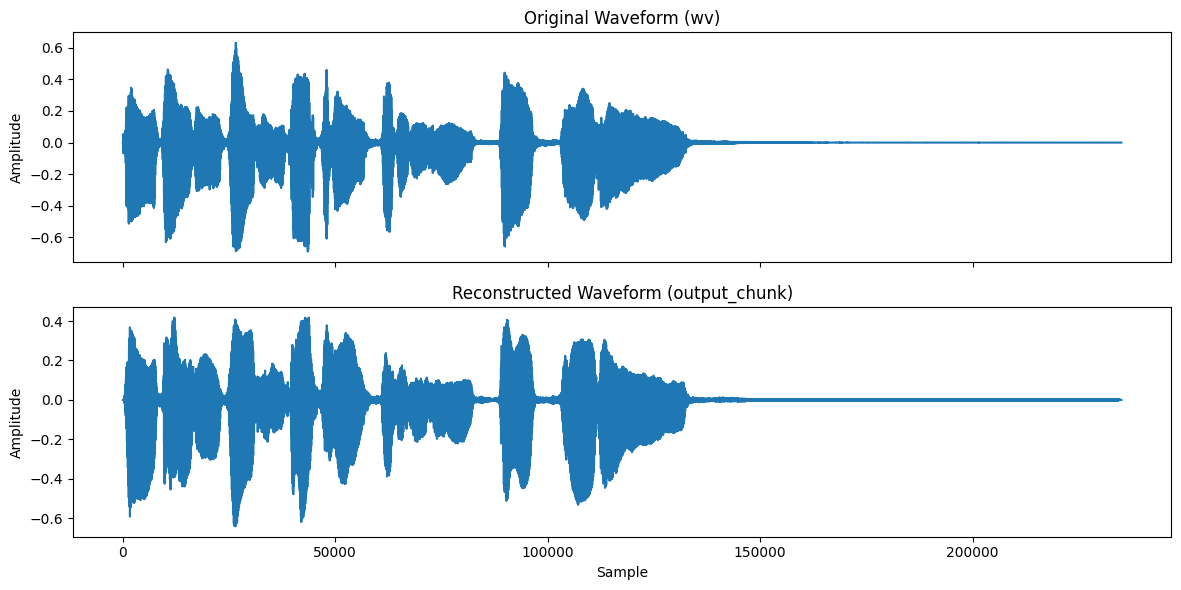

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axs[0].plot(wv[0].cpu().numpy())
axs[0].set_title('Original Waveform (wv)')
axs[0].set_ylabel('Amplitude')

axs[1].plot(output_chunk[0].cpu().numpy())
axs[1].set_title('Reconstructed Waveform (output_chunk)')
axs[1].set_xlabel('Sample')
axs[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

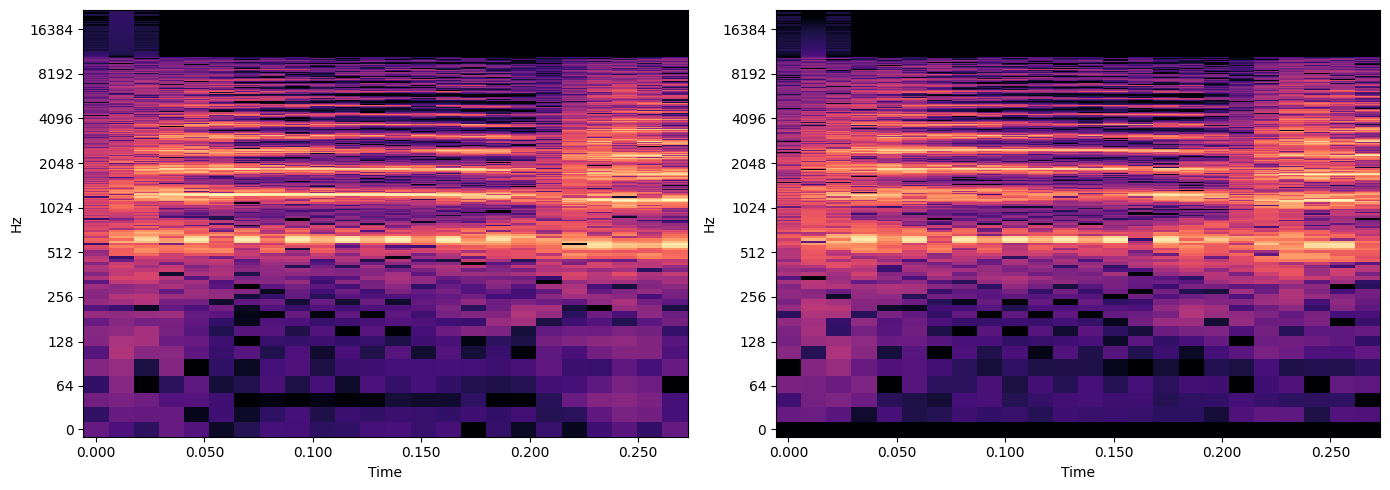

In [48]:
# D = librosa.amplitude_to_db(np.abs(librosa.stft(train_data[0][0].cpu().detach().numpy(), n_fft=2048*4)), ref=np.max)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
img = librosa.display.specshow(librosa.amplitude_to_db(repr_encoder[0,0].cpu().numpy()), x_axis='time', y_axis='log', ax=ax[0], sr=44100)
times = librosa.times_like(repr_encoder[0,0].cpu().numpy(), sr=sr)
img = librosa.display.specshow(librosa.amplitude_to_db(repr_encoder[0,1].cpu().numpy()), x_axis='time', y_axis='log', ax=ax[1], sr=44100)

plt.tight_layout()
plt.show()

In [49]:
max_sample_length = (int(max_waveform_length_encode/hparams.hop)//downscaling_factor)*downscaling_factor
sample_length = repr_encoder.shape[-1]
print(f'max sample length: {max_sample_length}, sample length: {sample_length}, repr_encoder.shape: {repr_encoder.shape}')



max sample length: 5160, sample length: 24, repr_encoder.shape: torch.Size([1, 2, 1024, 24])


In [50]:
%%time

x = gen.encoder.conv_inp(repr_encoder)
if hparams.frequency_scaling:
    x = gen.encoder.gain(x)

# DOWNSAMPLING
k = 0
for i,num_layers in enumerate(gen.encoder.layers_list):
    for num in range(num_layers):
        x = gen.encoder.down_layers[k](x)
        k = k+1
    if i!=(len(gen.encoder.layers_list)-1):
        x = gen.encoder.down_layers[k](x)
        k = k+1

if hparams.pre_normalize_2d_to_1d:
    x = gen.encoder.prenorm_1d_to_2d(x)

x = x.reshape(x.size(0), x.size(1) * x.size(2), x.size(3))

for layer in gen.encoder.bottleneck_layers:
    x = layer(x)
        
x = gen.encoder.norm_out(x)
x = gen.encoder.activation_out(x)
x = gen.encoder.conv_out(x)
x = gen.encoder.activation_bottleneck(x)

latent = x/sigma_rescale
print(f'Shape of latents: {latent.shape}')

Shape of latents: torch.Size([1, 64, 3])
CPU times: user 289 ms, sys: 75.5 ms, total: 364 ms
Wall time: 448 ms


In [51]:
with torch.no_grad():
    this_latent = latent*gen.sigma_rescale

    sample_length = int(this_latent.shape[-1]*downscaling_factor)
    init_noise = torch.randn((1, hparams.data_channels, hparams.hop*2, sample_length)).to(latent.device)*hparams.sigma_max
    decoded_spec_i = gen.forward_generator(this_latent, init_noise)[...,:27]

In [52]:
decoded_spec_i.shape

torch.Size([1, 2, 1024, 24])

In [53]:
x = torch.nn.functional.pad(decoded_spec_i, (0,0,0,1))
real,imag = torch.chunk(x, 2, -3)
X = torch.complex(real.squeeze(-3),imag.squeeze(-3))
X.shape

torch.Size([1, 1025, 24])

In [54]:
output_chunk_1 = istft_processor.process_chunk(X)
output_chunk_2 = istft_processor.process_chunk(X)
output_chunk_3 = istft_processor.process_chunk(X)
output_chunk_4 = istft_processor.process_chunk(X)

Shape after irfft: torch.Size([1, 24, 2048])
Shape of inv_window: torch.Size([2048])
Shape after irfft: torch.Size([1, 24, 2048])
Shape of inv_window: torch.Size([2048])
Shape after irfft: torch.Size([1, 24, 2048])
Shape of inv_window: torch.Size([2048])
Shape after irfft: torch.Size([1, 24, 2048])
Shape of inv_window: torch.Size([2048])


In [55]:
output_chunk_2.shape

torch.Size([1, 12288])

In [56]:
output_chunk = torch.cat([output_chunk_1, output_chunk_2, output_chunk_3, output_chunk_4], dim=-1)

In [82]:
output_chunk.shape

torch.Size([1, 208896])

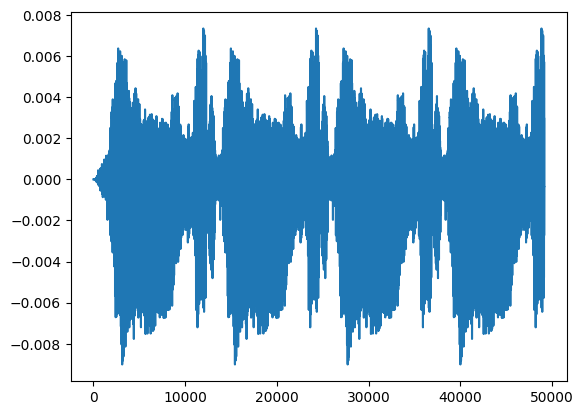

In [58]:
plt.plot(output_chunk[0].cpu().numpy(), label='Original')
plt.show()

In [59]:

print('Reconstructed')
IPython.display.display(IPython.display.Audio(output_chunk.cpu().numpy(), rate=sr))

Reconstructed


In [34]:
import torch
from music2latent.scripted_audio import wv2realimag, realimag2wv, normalize_complex, denormalize_complex, overlap_and_add, inverse_stft_window
import matplotlib.pyplot as plt


In [21]:
repr_encoder = wv2realimag(wvs[0], hparams.hop, 4)
repr_encoder.shape

torch.Size([1, 2, 1024, 24])

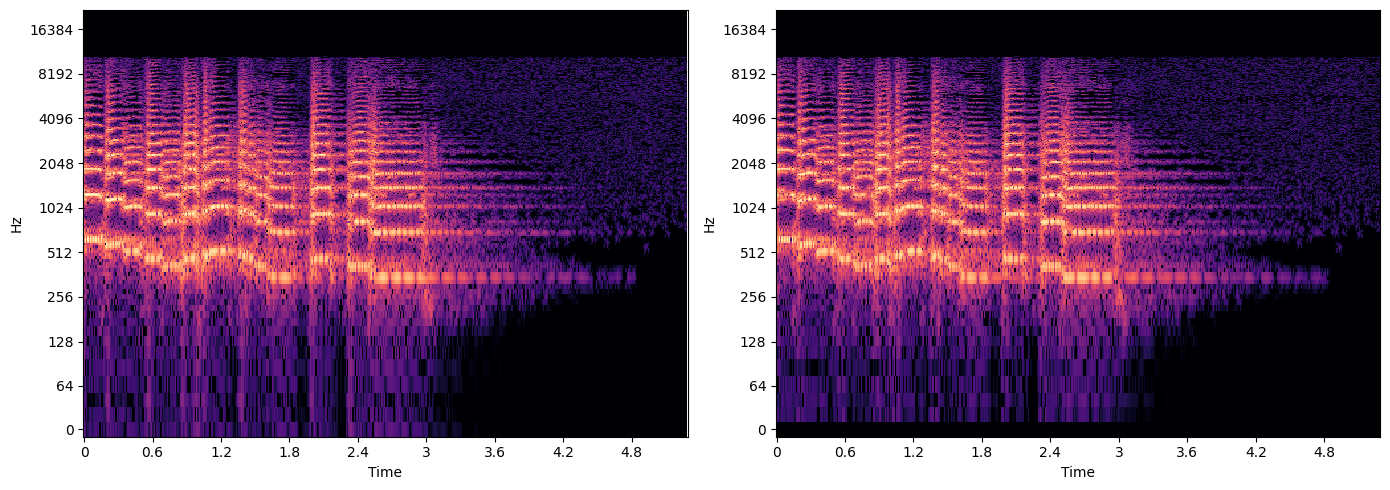

In [12]:
# D = librosa.amplitude_to_db(np.abs(librosa.stft(train_data[0][0].cpu().detach().numpy(), n_fft=2048*4)), ref=np.max)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
img = librosa.display.specshow(librosa.amplitude_to_db(repr_encoder[0,0].cpu().numpy()), x_axis='time', y_axis='log', ax=ax[0], sr=44100)
times = librosa.times_like(repr_encoder[0,0].cpu().numpy(), sr=sr)
img = librosa.display.specshow(librosa.amplitude_to_db(repr_encoder[0,1].cpu().numpy()), x_axis='time', y_axis='log', ax=ax[1], sr=44100)

plt.tight_layout()
plt.show()

In [13]:
max_sample_length = (int(max_waveform_length_encode/hparams.hop)//downscaling_factor)*downscaling_factor
sample_length = repr_encoder.shape[-1]
print(f'max sample length: {max_sample_length}, sample length: {sample_length}, repr_encoder.shape: {repr_encoder.shape}')

max sample length: 5160, sample length: 456, repr_encoder.shape: torch.Size([1, 2, 1024, 456])


In [14]:
%%time

x = gen.encoder.conv_inp(repr_encoder)
if hparams.frequency_scaling:
    x = gen.encoder.gain(x)

# DOWNSAMPLING
k = 0
for i,num_layers in enumerate(gen.encoder.layers_list):
    for num in range(num_layers):
        x = gen.encoder.down_layers[k](x)
        k = k+1
    if i!=(len(gen.encoder.layers_list)-1):
        x = gen.encoder.down_layers[k](x)
        k = k+1

if hparams.pre_normalize_2d_to_1d:
    x = gen.encoder.prenorm_1d_to_2d(x)

x = x.reshape(x.size(0), x.size(1) * x.size(2), x.size(3))

for layer in gen.encoder.bottleneck_layers:
    x = layer(x)
        
x = gen.encoder.norm_out(x)
x = gen.encoder.activation_out(x)
x = gen.encoder.conv_out(x)
x = gen.encoder.activation_bottleneck(x)

latent = x/sigma_rescale

CPU times: user 285 ms, sys: 107 ms, total: 392 ms
Wall time: 357 ms


In [15]:
latent.shape

torch.Size([1, 64, 57])

In [33]:
def get_sigma(i, k):
    return (hparams.sigma_min**(1./hparams.rho) + ((i-1)/(k-1))*(hparams.sigma_max**(1./hparams.rho)-hparams.sigma_min**(1./hparams.rho)))**hparams.rho

sigma = get_sigma(1+1-0, 1+1)
sigma

80.0

In [34]:
def get_c(sigma):
    sigma_correct = hparams.sigma_min
    c_skip = (hparams.sigma_data**2.)/(((sigma-sigma_correct)**2.) + (hparams.sigma_data**2.))
    c_out = (hparams.sigma_data*(sigma-sigma_correct))/(((hparams.sigma_data**2.) + (sigma**2.))**0.5)
    c_in = 1./(((sigma**2.)+(hparams.sigma_data**2.))**0.5)
    return c_skip.reshape(-1,1,1,1), c_out.reshape(-1,1,1,1), c_in.reshape(-1,1,1,1)

In [18]:
latent.shape

torch.Size([1, 64, 57])

In [19]:
# latent = torch.cat([latent[:,:,:1]]*57, dim=2)

In [20]:
# latent = latent/sigma_rescale

In [21]:
latent.shape

torch.Size([1, 64, 57])

In [24]:
downscaling_factor

8

In [30]:
latent.shape

torch.Size([1, 64, 57])

In [47]:
%%time

     
with torch.no_grad():
    spec_recs = []
    for i in range(6):
        this_latent = latent[:,:,i*8:(i+1)*8]*gen.sigma_rescale

        sample_length = int(this_latent.shape[-1]*downscaling_factor)
        init_noise = torch.randn((num_samples, hparams.data_channels, hparams.hop*2, sample_length)).to(latent.device)*hparams.sigma_max
        decoded_spec_i = gen.forward_generator(this_latent, init_noise)
        # wv_rec_i = gen.decode(latent[:,:,i*8:(i+1)*8]).unsqueeze(0)
        spec_recs.append(decoded_spec_i)
    spec_rec = torch.cat(spec_recs, dim=-1)
    spec_rec.shape

CPU times: user 202 ms, sys: 99.3 ms, total: 301 ms
Wall time: 313 ms


In [48]:
spec_rec.shape

torch.Size([1, 2, 1024, 384])

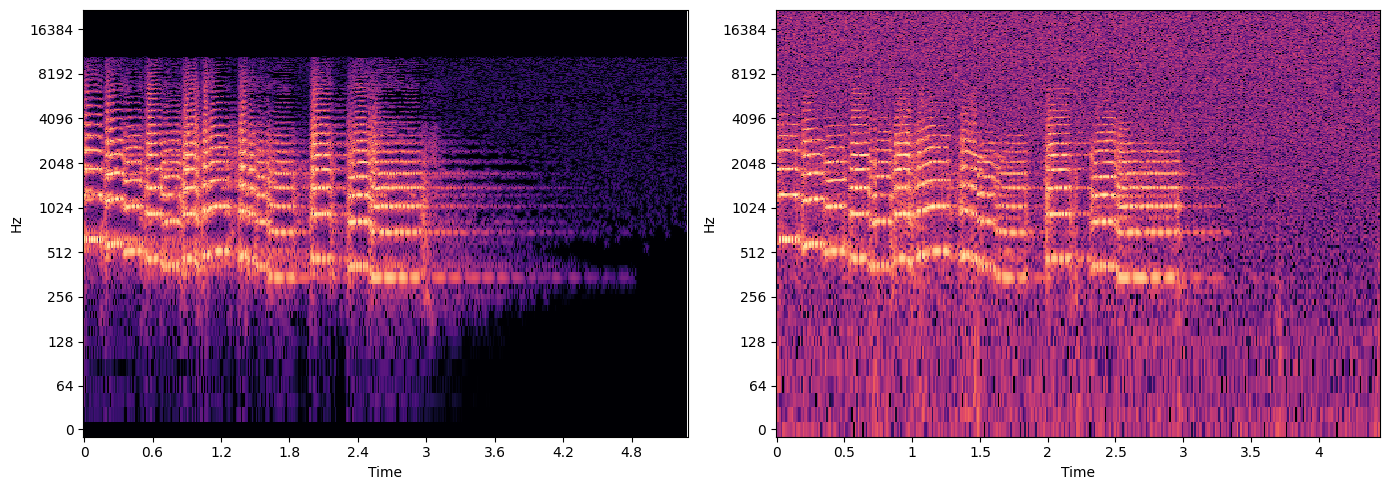

In [49]:
# D = librosa.amplitude_to_db(np.abs(librosa.stft(train_data[0][0].cpu().detach().numpy(), n_fft=2048*4)), ref=np.max)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
img = librosa.display.specshow(librosa.amplitude_to_db(repr_encoder[0,1].cpu().numpy()), x_axis='time', y_axis='log', ax=ax[0], sr=44100)
times = librosa.times_like(repr_encoder[0,0].cpu().numpy(), sr=sr)
img = librosa.display.specshow(librosa.amplitude_to_db(spec_rec[0,1].cpu().numpy()), x_axis='time', y_axis='log', ax=ax[1], sr=44100)

plt.tight_layout()
plt.show()

In [27]:
wv_rec = realimag2wv(spec_rec, hparams.hop, 4)

In [50]:
print('Original')
IPython.display.display(IPython.display.Audio(wv.cpu().numpy(), rate=sr))
print('Reconstructed')
IPython.display.display(IPython.display.Audio(wv_rec.squeeze().cpu().numpy(), rate=sr))

Original


Reconstructed
